# Training model (EPL)

In [45]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime
import matplotlib.ticker as mtick
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy.stats import poisson,skellam

In [2]:
url_train = 'https://fbref.com/en/comps/9/2020-2021/schedule/2020-2021-Premier-League-Scores-and-Fixtures'
url_test1 = 'https://fbref.com/en/comps/9/2021-2022/schedule/2021-2022-Premier-League-Scores-and-Fixtures'
url_test2 = 'https://fbref.com/en/comps/9/2022-2023/schedule/2022-2023-Premier-League-Scores-and-Fixtures'


#Reading fixture
train = pd.read_html(url_train)[0]
test1 = pd.read_html(url_test1)[0]
test2 = pd.read_html(url_test2)[0]

#Casting cate and creating variable season
train["Date"] = pd.to_datetime(train["Date"])
test1["Date"] = pd.to_datetime(test1["Date"])
test2["Date"] = pd.to_datetime(test2["Date"])

train["Season"] = "2020-2021"
test1["Season"] = "2021-2022"
test2["Season"] = "2022-2023"


#Joining dataframes
train = pd.concat([train,test1,test2],ignore_index=True)


#Keeping necessary variables and splitting score to get home and away goals
train = train[["Date","Season","Home","xG","Score","xG.1","Away"]].dropna()
train[["Home_g","Away_g"]]=train["Score"].str.split("–",expand=True)
train.drop(columns = ["Score"],inplace=True)
train = train.sort_values('Date').reset_index(drop=True)

In [3]:
# Creating dataframes for home and away
home = train[["Date","Season","Home","xG","xG.1","Home_g","Away_g"]]
away = train[["Date","Season","Away","xG","xG.1","Home_g","Away_g"]]

# Changing columns to get generic name
home.columns = ["Date","Season","Team","xG","Conceded xG","Goals","Conceded Goals"]
away.columns = ["Date","Season","Team","Conceded xG","xG","Conceded Goals","Goals"]

home["Host"] = 1
away["Host"] = 0  

#Joining home and away to groupby team
goals = pd.concat([home,away])
goals = goals.sort_values("Date")

#Creating cum average variables
goals["xG (rolling)"]=goals.groupby(["Season","Team"])["xG"].transform(lambda x: x.shift().expanding().mean()).round(2)
goals["Conceded xG (rolling)"]=goals.groupby(["Season","Team"])["Conceded xG"].transform(lambda x: x.shift().expanding().mean()).round(2)
goals["Goals (rolling)"]=goals.groupby(["Season","Team"])["Goals"].transform(lambda x: x.shift().expanding().mean()).round(2)
goals["Conceded Goals (rolling)"]=goals.groupby(["Season","Team"])["Conceded Goals"].transform(lambda x: x.shift().expanding().mean()).round(2)

#Splitting dataframes to join again
goals_h = goals.loc[goals["Host"]==1,["xG (rolling)","Conceded xG (rolling)","Goals (rolling)","Conceded Goals (rolling)"]]
goals_a = goals.loc[goals["Host"]==0,["xG (rolling)","Conceded xG (rolling)","Goals (rolling)","Conceded Goals (rolling)"]]


goals_h.columns = ["xG (rolling) Home","Conceded xG (rolling) Home","Goals (rolling) Home","Conceded Goals (rolling) Home"]
goals_a.columns = ["xG (rolling) Away","Conceded xG (rolling) Away","Goals (rolling) Away","Conceded Goals (rolling) Away"]


In [4]:
# Joining average dataframe to match dataframe
train_df = train.merge(goals_h,how="left",right_index=True,left_index=True).merge(goals_a,how="left",right_index=True,left_index=True).dropna()

train_df["y_win"] =  train_df.apply(lambda x: 0 if x["Home_g"] > x["Away_g"] else (1 if x["Away_g"]>x["Home_g"] else 2),axis=1)
train_df["y_bts"] = ((train_df["Home_g"].astype(int)>0)&(train_df["Away_g"].astype(int)>0)).astype(int)

## XGBoostClassifier

In [10]:
#((train_df["Home_g"].astype(int)>0)&(train_df["Away_g"].astype(int)>0)).astype(int)
df_xgb = train_df[["Season","Home","Away","xG (rolling) Home","Conceded xG (rolling) Home","Goals (rolling) Home","Conceded Goals (rolling) Home","xG (rolling) Away","Conceded xG (rolling) Away","Goals (rolling) Away","Conceded Goals (rolling) Away","y_win"]]

df_xgb = pd.get_dummies(df_xgb,columns=["Home","Away"])

X_train = df_xgb.loc[df_xgb.Season.isin(["2020-2021","2021-2022"])].drop(columns=["Season","y_win"])
X_test = df_xgb.loc[~df_xgb.Season.isin(["2020-2021","2021-2022"])].drop(columns=["Season","y_win"])
y_train = df_xgb.loc[df_xgb.Season.isin(["2020-2021","2021-2022"]),"y_win"]
y_test = df_xgb.loc[~df_xgb.Season.isin(["2020-2021","2021-2022"]),"y_win"]

In [11]:
# Set up the XGBoost classifier
xgb_model = XGBClassifier(objective='multi:softmax')

# Set up the parameter grid to search
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.5],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 0.1, 0.5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'min_child_weight': [1, 3, 5]
}

# Set up the randomized grid search
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=50, cv=5, n_jobs=-1)

# Fit the randomized grid search to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters found
print(random_search.best_params_)

{'subsample': 0.7, 'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}


In [12]:
best_params = random_search.best_params_

# Create an XGBClassifier object with the best hyperparameters
xgb_model = XGBClassifier(objective='multi:softmax', 
                              n_estimators=best_params['n_estimators'], 
                              max_depth=best_params['max_depth'], 
                              learning_rate=best_params['learning_rate'],
                              subsample=best_params['subsample'], 
                              colsample_bytree=best_params['colsample_bytree'], 
                              gamma=best_params['gamma'], 
                              reg_alpha=best_params['reg_alpha'], 
                              reg_lambda=best_params['reg_lambda'],
                              min_child_weight=best_params['min_child_weight'])

# Fit the XGBClassifier to the training data
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [13]:
from sklearn.metrics import classification_report

target_names = ['Home', 'Away', 'Draw']
print(classification_report(y_test, xgb_model.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

        Home       0.59      0.72      0.65       180
        Away       0.41      0.55      0.47       105
        Draw       0.50      0.06      0.11        85

    accuracy                           0.52       370
   macro avg       0.50      0.44      0.41       370
weighted avg       0.52      0.52      0.47       370



In [20]:
print(f"Accuracy {accuracy_score(y_test, xgb_model.predict(X_test)):.2f}")

Accuracy 0.52


In [21]:
xgb_accuracy = accuracy_score(y_test, xgb_model.predict(X_test))

## Poisson Model

In [15]:
home_poisson=train_df[["Season","Home","Home_g","xG (rolling) Home","Conceded xG (rolling) Home","Goals (rolling) Home","Conceded Goals (rolling) Home","xG (rolling) Away","Conceded xG (rolling) Away","Goals (rolling) Away","Conceded Goals (rolling) Away"]]
away_poisson=train_df[["Season","Away","Away_g","xG (rolling) Home","Conceded xG (rolling) Home","Goals (rolling) Home","Conceded Goals (rolling) Home","xG (rolling) Away","Conceded xG (rolling) Away","Goals (rolling) Away","Conceded Goals (rolling) Away"]]

home_poisson.columns = ["Season","Team","Goals","xG_for_T","xG_against_T","G_for_T","G_against_T","xG_for_O","xG_against_O","G_for_O","G_against_O"]
away_poisson.columns = ["Season","Team","Goals","xG_for_O","xG_against_O","G_for_O","G_against_O","xG_for_T","xG_against_T","G_for_T","G_against_T"]

home_poisson["Home"] = 1
away_poisson["Home"] = 0

df_poisson = home_poisson.append(away_poisson,ignore_index=True)
df_poisson["Goals"] = df_poisson["Goals"].astype(int)
df_poisson.head()

,Season,Team,Goals,xG_for_T,xG_against_T,G_for_T,G_against_T,xG_for_O,xG_against_O,G_for_O,G_against_O,Home
0,2020-2021,Everton,5,1.2,1.1,1.0,0.0,0.4,2.8,0.0,3.0,1
1,2020-2021,Leeds United,4,0.3,2.7,3.0,4.0,0.1,1.9,0.0,3.0,1
2,2020-2021,Arsenal,2,1.9,0.1,3.0,0.0,1.0,1.6,0.0,2.0,1
3,2020-2021,Southampton,2,0.9,1.1,0.0,1.0,1.1,1.2,0.0,1.0,1
4,2020-2021,Newcastle Utd,0,1.6,1.0,2.0,0.0,1.1,1.2,1.0,3.0,1


In [16]:
#fit the model
poisson_model = smf.glm(formula="Goals ~ xG_for_T  + G_against_T + xG_for_O + xG_against_O + Home", data=df_poisson[df_poisson.Season!='2022-2023'].drop(columns="Season"),
                    family=sm.families.Poisson()).fit()
#print summary
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Goals   No. Observations:                 1476
Model:                            GLM   Df Residuals:                     1470
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2175.4
Date:                Sat, 12 Aug 2023   Deviance:                       1765.3
Time:                        21:08:53   Pearson chi2:                 1.60e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1323
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.3427      0.228     -1.502      0.133      -0.790       0.104
xG_for_T         0.4828      0.058      8.378      0.000       0.370       0.596
G_against_T     -0.1557      0.050     -3.118      0.002      -0.254      -0.058
xG_for_O        -0.2566      0.072     -3.543      0.000      -0.398      -0.115
xG_against_O     0.3690      0.080      4.618      0.000       0.212       0.526
Home             0.0927      0.045      2.083      0.037       0.005       0.180
================================================================================
"""

In [17]:
def get_probabilities(xG_home, xG_conceded_home,Goals_home, conceded_Goals_home,xG_away,xG_conceded_away, Goals_away,conceded_Goals_away,model = poisson_model):

    home_data = pd.DataFrame(data={'xG_for_T':xG_home,'xG_against_T':xG_conceded_home,'G_for_T':Goals_home,'G_against_T':conceded_Goals_home,
                                   'xG_for_O':xG_away,'xG_against_O':xG_conceded_away,'G_for_O':Goals_away,'G_against_O':conceded_Goals_away,'Home':1},index=[1])
    away_data = pd.DataFrame(data={'xG_for_T':xG_away,'xG_against_T':xG_conceded_away,'G_for_T':Goals_away,'G_against_T':conceded_Goals_away,
                                   'xG_for_O':xG_home,'xG_against_O':xG_conceded_home,'G_for_O':Goals_home,'G_against_O':conceded_Goals_home,'Home':0},index=[1])
    
    # Get avg goals predicted by model
    home_avg_goals = model.predict(home_data).values[0]
    away_avg_goals = model.predict(away_data).values[0]

    # Get probability of score 1 to 5 goals for each team
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, 5)] for team_avg in [home_avg_goals, away_avg_goals]]

    #Calculate joint probability
    joint_proba=np.outer(np.array(team_pred[0]), np.array(team_pred[1]))

    #Calculate probability for Home, Draw and Away
    probability = pd.Series([1-np.sum(np.triu(joint_proba, 1))-np.sum(np.diag(joint_proba)),np.sum(np.diag(joint_proba)),np.sum(np.triu(joint_proba, 1))],index=['Home','Draw','Away'])

    return probability

def get_probabilities_btts(xG_home, xG_conceded_home,Goals_home, conceded_Goals_home,xG_away,xG_conceded_away, Goals_away,conceded_Goals_away,model = poisson_model):

    home_data = pd.DataFrame(data={'xG_for_T':xG_home,'xG_against_T':xG_conceded_home,'G_for_T':Goals_home,'G_against_T':conceded_Goals_home,
                                   'xG_for_O':xG_away,'xG_against_O':xG_conceded_away,'G_for_O':Goals_away,'G_against_O':conceded_Goals_away,'Home':1},index=[1])
    away_data = pd.DataFrame(data={'xG_for_T':xG_away,'xG_against_T':xG_conceded_away,'G_for_T':Goals_away,'G_against_T':conceded_Goals_away,
                                   'xG_for_O':xG_home,'xG_against_O':xG_conceded_home,'G_for_O':Goals_home,'G_against_O':conceded_Goals_home,'Home':0},index=[1])
    
    # Get avg goals predicted by model
    home_avg_goals = model.predict(home_data).values[0]
    away_avg_goals = model.predict(away_data).values[0]

    # Get probability of score 1 to 5 goals for each team
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, 5)] for team_avg in [home_avg_goals, away_avg_goals]]

    #Calculate joint probability
    joint_proba=np.outer(np.array(team_pred[0]), np.array(team_pred[1]))

    #Calculate probability for Both teams score
    probability = joint_proba[1:,1:].sum()


    return probability


In [18]:
train_columns = ['xG (rolling) Home', 'Conceded xG (rolling) Home',
       'Goals (rolling) Home', 'Conceded Goals (rolling) Home',
       'xG (rolling) Away', 'Conceded xG (rolling) Away',
       'Goals (rolling) Away', 'Conceded Goals (rolling) Away',"Home","Away"]

In [19]:
train_df[["0","2","1"]] = train_df[train_columns].apply(lambda x: get_probabilities(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]),axis=1)
train_df["Predicted_poisson"]=train_df[["0","2","1"]].idxmax(axis=1).astype(int)
acc_poisson = (train_df.loc[train_df.Season=="2022-2023","Predicted_poisson"]==train_df.loc[train_df.Season=="2022-2023","y_win"]).mean().round(2)
print(f"Poisson accuracy: {acc_poisson:.2f}")

Poisson accuracy: 0.54


In [42]:
plt.style.use('fivethirtyeight')

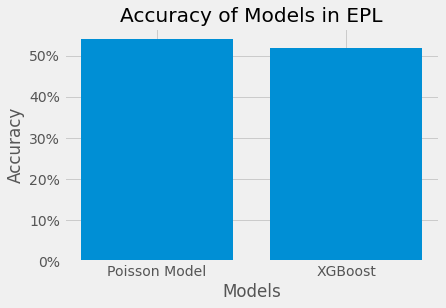

In [44]:
fig, ax = plt.subplots()
ax.bar(["Poisson Model","XGBoost"],[acc_poisson,xgb_accuracy])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title("Accuracy of Models in EPL")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Models")
plt.savefig('Comparison.png', dpi=300)